In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
import wandb

import json
import pickle
from copy import deepcopy
from pathlib import Path

import gurobipy
from gurobipy import GRB
import dgl
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.problem import get_model
from src.dataset import MultiTargetDataset
from src.net import InstanceGCN
from src.utils import load_from_wandb

In [12]:
run = wandb.Api().run('brunompac/sat-gnn/runs/yfbh4vsp')
run.summary

{'last_test_mean_gaps': [4.25e+19, 4.333333333333334e+19, 4.5e+19, 4.333333333333334e+19, 4.416666666666666e+19, 4.25e+19, 4.25e+19], '_wandb': {'runtime': 5528}, 'train_time_loss': 0.0073566436767578125, 'val_time_forward': 0.7985410690307617, 'val_loss_mean_acc': 0.8542272989276856, '_runtime': 665.6997752189636, 'last_test_runtimes': '...', 'val_loss_acc': {'values': [1, 0, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 4, 6, 5, 4, 6, 7, 11, 8, 6, 10, 9, 6, 10, 9, 3, 1], '_type': 'histogram', 'bins': [0.711808809746954, 0.7181891401124648, 0.7245694704779756, 0.7309498008434864, 0.7373301312089972, 0.7437104615745079, 0.7500907919400187, 0.7564711223055295, 0.7628514526710403, 0.769231783036551, 0.7756121134020618, 0.7819924437675726, 0.7883727741330834, 0.7947531044985942, 0.8011334348641049, 0.8075137652296157, 0.8138940955951265, 0.8202744259606373, 0.826654756326148, 0.8330350866916588, 0.8394154170571696, 0.8457957474226804, 0.8521760777881912, 0.8585564081537019, 0.8649367385192127

In [23]:
run.summary['last_test_ns']

[0, 50, 100, 200, 500, 1000, -1]

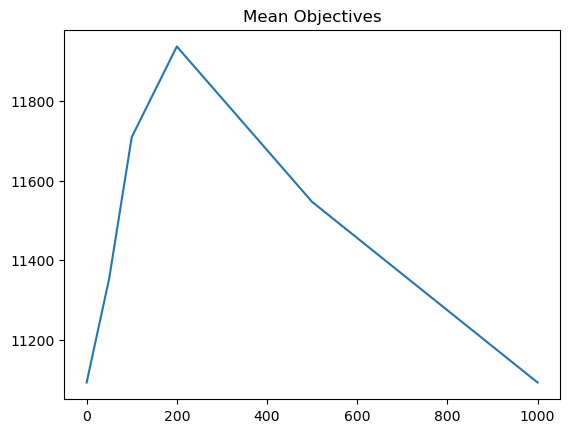

In [28]:
plt.plot(run.summary['last_test_ns'][:-1], run.summary['last_test_mean_objs'][:-1])
plt.title('Mean Objectives')
plt.show()

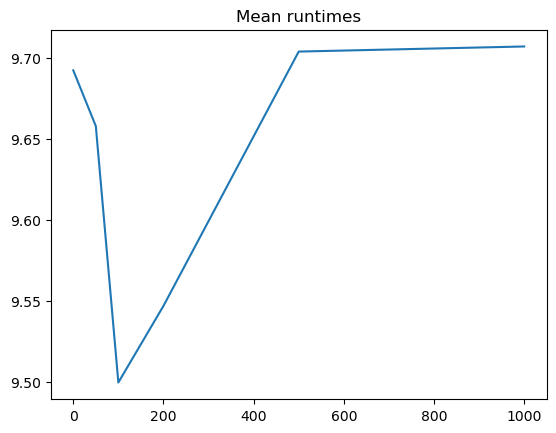

In [29]:
plt.plot(run.summary['last_test_ns'][:-1], run.summary['last_test_mean_runtimes'][:-1])
plt.title('Mean runtimes')
plt.show()

# Experiments

In [6]:
instances_dir = Path('../data/raw')
instances_fpaths = list(instances_dir.glob('97_*.json'))

net = InstanceGCN(1, readout_op=None)
net = load_from_wandb(net, 'vty6z1q3', 'sat-gnn', 'model_last')
net.eval()

ds = MultiTargetDataset(instances_fpaths, split='val', return_model=True)

g, _, m = ds[0]
m

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


<gurobi.Model MIP instance Unnamed: 10163 constrs, 3783 vars, Parameter changes: TimeLimit=60.0, Username=(user-defined), LogToConsole=0>

In [14]:
g1, _, m = ds[0]

with torch.no_grad():
    p1_hat = torch.sigmoid(net(g1))

g2, _, m = ds[1]

with torch.no_grad():
    p2_hat = torch.sigmoid(net(g2))

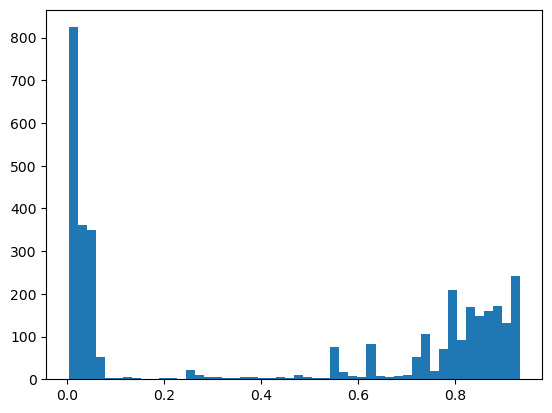

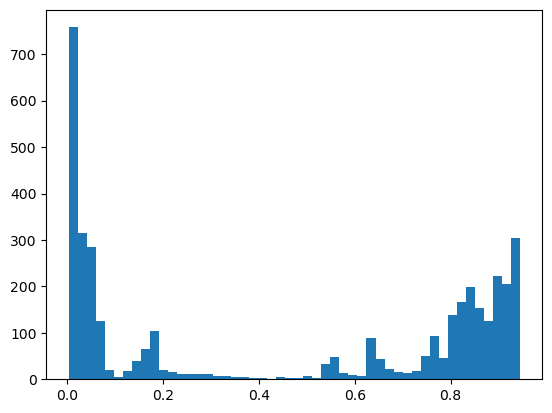

In [16]:
plt.hist(p1_hat, bins=50)
plt.show()
plt.hist(p2_hat, bins=50)
plt.show()

In [19]:
m.Runtime

0.0

In [33]:
def get_ef_times_n_vars(graph, model, net, name=None, plot=True, timeout=60):
    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.setParam('TimeLimit', timeout)
    model_.update()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal
    baseline_gap = model_.MIPGap

    with torch.no_grad():
        x_hat = torch.sigmoid(net(graph)).squeeze(0)

    most_certain_idx  = (x_hat - 0.5).abs().sort(descending=True).indices


    runtimes = list()
    objs = list()
    gaps = list()
    ns = list()
    for n in [0, 50, 100, 150, 200, 300, 500, 1000, len(x_hat)]:
    # for n in [0, 50, 100, 150]:
        if n == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            gaps.append(baseline_gap)
            ns.append(n)
            continue

        fixed_x_hat = (x_hat[most_certain_idx[:n]] > .5).to(x_hat)
        fixed_vars_names = vars_names[most_certain_idx[:n]]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).lb = fixed_var_X
            model_.getVarByName(fixed_var_name).ub = fixed_var_X

        model_.setParam('TimeLimit', timeout)
        model_.update()
        model_.optimize()

        if model_.status not in [2, 9]:
            print('early fixing with n=',n,' made the optimizatio terminate with status ',model_.status)
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        gaps.append(model_.MIPGap)
        ns.append(n)

    objs = [100 * o / max(objs) for o in objs]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        ax.set_xlim(0,max(ns))

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objective')
        obj_ax.legend(loc=4)
        obj_ax.set_ylim(min(objs), 100)
        obj_ax.set_ylabel('Objective')

        fig.show()

    return ns, runtimes, objs, gaps

In [41]:
x_vars = [v.varname for v in m.getVars() if 'x(' in v.varname]
js = {int(var[len('x('):].split(',')[0]) for var in x_vars}
ts = {int(var.split(',')[1][:-1]) for var in x_vars}

In [35]:
g, _, m = ds[2]

ns, runtimes, objs, gaps = get_ef_times_n_vars(g, m, net, timeout=10, plot=False)
ns, runtimes, objs, gaps

early fixing with n= 500  made the optimizatio terminate with status  3


([0, 50, 100, 150, 200, 300],
 [10.012699842453003,
  10.0067880153656,
  10.004565954208374,
  10.008992910385132,
  10.008025884628296,
  10.010357141494751],
 [100.0, 100.0, 100.0, 100.0, 100.0, 100.0],
 [0.007909948281107393,
  0.004867660480681472,
  0.0027380590203833284,
  0.000608457560085184,
  0.000304228780042592,
  0.000304228780042592])

# All Results

[1.         0.99719525 0.97957785 0.97974287 0.99217731 0.98705491
 0.9996677 ]
[100.         108.12132093 106.41470837 114.45212305 112.09066301
 102.01372101 119.30779305]


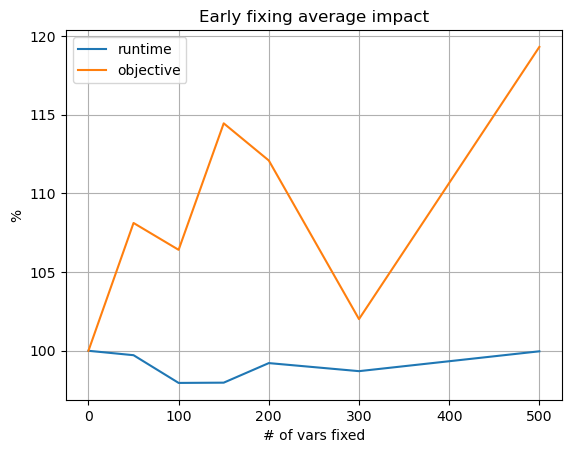

In [3]:
from collections import OrderedDict

with open('../scip_ef_performance_0vj9x4zz.pkl', 'rb') as f:
    ef_perfs = pickle.load(f)

ns = [0, 50, 100, 150, 200, 300, 500,]
# ns = [0, 50, 100, 200, 500, -1]

runtimes = OrderedDict([(n, list()) for n in ns])
objs = OrderedDict([(n, list()) for n in ns])

for ef_perf in ef_perfs:
    for i in range(len(ef_perf['ns'])):
        if not np.isnan(ef_perf['objs'][i]):
            runtimes[ns[i]].append(ef_perf['runtimes'][i] / ef_perf['runtimes'][0])
            objs[ns[i]].append(ef_perf['objs'][i])

mean_runtimes = np.array([sum(runtimes[n]) / len(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
max_runtimes = np.array([max(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
min_runtimes = np.array([min(runtimes[n]) for n in ns if len(runtimes[n]) != 0])

mean_objs = np.array([sum(objs[n]) / len(objs[n]) for n in ns if len(objs[n]) != 0])

print(mean_runtimes)
print(mean_objs)
plt.plot(ns[:len(mean_runtimes)], mean_runtimes * 100, label='runtime')
plt.plot(ns[:len(mean_objs)], mean_objs, label='objective')
# plt.fill_between(ns[:len(mean_runtimes)], min_runtimes * 100, max_runtimes * 100, alpha=0.5)
plt.title('Early fixing average impact')
plt.xlabel('# of vars fixed')
plt.ylabel('%')
# plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

[1.         0.99910501 0.97985473 0.97966186 0.99206838 0.98690264
 0.99992078]
[100.         108.37362702 107.59954767 114.41693266 112.2885402
 102.13084614 119.30277978]


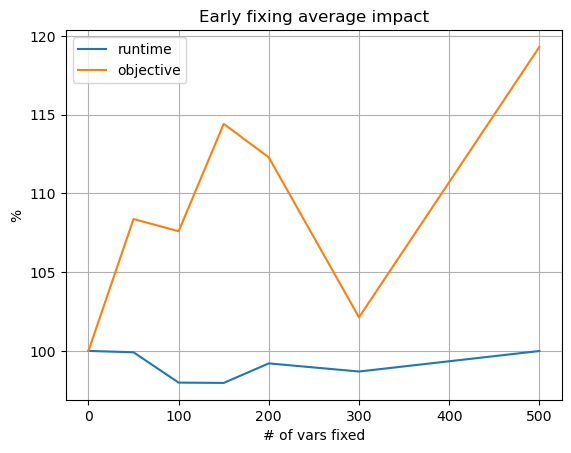

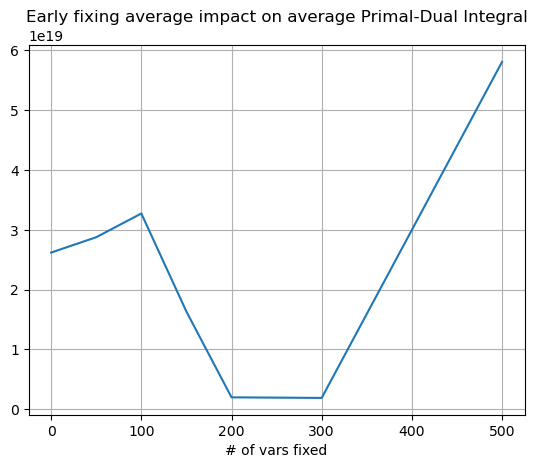

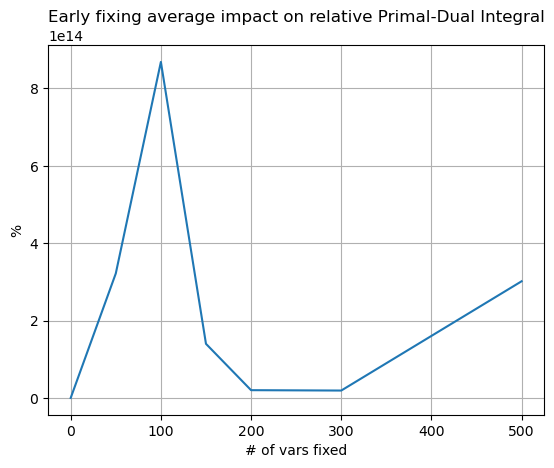

In [7]:
from collections import OrderedDict

with open('../new_scip_ef_performance_0vj9x4zz.pkl', 'rb') as f:
    ef_perfs = pickle.load(f)

ns = [0, 50, 100, 150, 200, 300, 500,]
# ns = [0, 50, 100, 200, 500, -1]

runtimes = OrderedDict([(n, list()) for n in ns])
objs = OrderedDict([(n, list()) for n in ns])
pd_integrals = OrderedDict([(n, list()) for n in ns])
relative_pd_integrals = OrderedDict([(n, list()) for n in ns])

for ef_perf in ef_perfs:
    for i in range(len(ef_perf['ns'])):
        if not np.isnan(ef_perf['objs'][i]):
            runtimes[ns[i]].append(ef_perf['runtimes'][i] / ef_perf['runtimes'][0])
            objs[ns[i]].append(ef_perf['objs'][i])
            pd_integrals[ns[i]].append(ef_perf['pd_integrals'][i])
            relative_pd_integrals[ns[i]].append(ef_perf['pd_integrals'][i] / ef_perf['pd_integrals'][0])

mean_runtimes = np.array([sum(runtimes[n]) / len(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
max_runtimes = np.array([max(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
min_runtimes = np.array([min(runtimes[n]) for n in ns if len(runtimes[n]) != 0])

mean_objs = np.array([sum(objs[n]) / len(objs[n]) for n in ns if len(objs[n]) != 0])

mean_pd_integrals = np.array([sum(pd_integrals[n]) / len(pd_integrals[n]) for n in ns if len(pd_integrals[n]) != 0])
mean_relative_pd_integrals = np.array([sum(relative_pd_integrals[n]) / len(relative_pd_integrals[n]) for n in ns if len(relative_pd_integrals[n]) != 0])

print(mean_runtimes)
print(mean_objs)
plt.plot(ns[:len(mean_runtimes)], mean_runtimes * 100, label='runtime')
plt.plot(ns[:len(mean_objs)], mean_objs, label='objective')
# plt.fill_between(ns[:len(mean_runtimes)], min_runtimes * 100, max_runtimes * 100, alpha=0.5)
plt.title('Early fixing average impact')
plt.xlabel('# of vars fixed')
plt.ylabel('%')
# plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.plot(ns[:len(mean_pd_integrals)], mean_pd_integrals)
plt.title('Early fixing average impact on average Primal-Dual Integral')
plt.xlabel('# of vars fixed')
plt.grid()
plt.show()

plt.plot(ns[:len(mean_relative_pd_integrals)], mean_relative_pd_integrals)
plt.title('Early fixing average impact on relative Primal-Dual Integral')
plt.xlabel('# of vars fixed')
plt.ylabel('%')
plt.grid()
plt.show()

In [6]:
pd_integrals

OrderedDict([(0,
              [16439.05990357909,
               23315.09539233804,
               30442.11965158002,
               38184.8091125196,
               2.994333e+20,
               100071.33,
               4.2530580000000003e+20,
               33964.507003971186,
               3.818428e+20,
               5.574764000000001e+20,
               47442.02897155751,
               3.5869010000000005e+20,
               40645.63835801744,
               4.343723e+20,
               1.5163000000000003e+20,
               3.1600000000253804e+16,
               47701.77628241818,
               55621.81358487321,
               1.900000000009134e+16,
               40647.31816083508,
               96836.89627290354,
               92272.7559341715,
               3.14000000000483e+16,
               127773.657778,
               109760.40020551188,
               100070.56999999999,
               94837.09630292006,
               130742.68661108408,
               112714.211

In [1]:
from collections import OrderedDict

with open('../scip_tr_performance_0vj9x4zz.pkl', 'rb') as f:
    ef_perfs = pickle.load(f)

# ns = [0, 50, 100, 150, 200, 300, 500,]
ns = [0, 50, 100, 200, 500, -1]

runtimes = OrderedDict([(n, list()) for n in ns])
objs = OrderedDict([(n, list()) for n in ns])

for ef_perf in ef_perfs:
    for i in range(len(ef_perf['ns'])):
        if not np.isnan(ef_perf['objs'][i]):
            runtimes[ns[i]].append(ef_perf['runtimes'][i] / ef_perf['runtimes'][0])
            objs[ns[i]].append(ef_perf['objs'][i])

mean_runtimes = np.array([sum(runtimes[n]) / len(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
max_runtimes = np.array([max(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
min_runtimes = np.array([min(runtimes[n]) for n in ns if len(runtimes[n]) != 0])

mean_objs = np.array([sum(objs[n]) / len(objs[n]) for n in ns if len(objs[n]) != 0])

print(mean_runtimes)
print(mean_objs)
plt.plot(ns[:len(mean_runtimes)], mean_runtimes * 100, label='runtime')
plt.plot(ns[:len(mean_objs)], mean_objs, label='objective')
# plt.fill_between(ns[:len(mean_runtimes)], min_runtimes * 100, max_runtimes * 100, alpha=0.5)
plt.title('Early fixing average impact')
plt.xlabel('# of vars fixed')
plt.ylabel('%')
# plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../scip_tr_performance_a9n0rx59.pkl'

In [20]:
runtimes[50]

[0.9999430054486791,
 0.8716592784768447,
 1.0000558968753646,
 0.9999105130650925,
 0.9954133683189594,
 1.0000631926759689,
 0.22824056642575155,
 0.999963002615715,
 1.000032099142953,
 1.0000313990925662,
 1.4091826215282066,
 1.0000328982136268,
 0.5931263975348536,
 1.0000379994566078,
 1.000087999709601,
 1.0000088993272107,
 0.9999710019370707,
 0.8635405981266958,
 1.00000009999924,
 1.171209339782612]

In [21]:
objs[50]

[100.58124174372523,
 100.02746498214776,
 94.53447727994916,
 88.33951380304903,
 99.84567901234568,
 117.98353909465021,
 99.52406134320465,
 100.03012955709545,
 100.0230255583698,
 100.03603603603604,
 100.0,
 87.63545429285912,
 100.0,
 99.4478527607362,
 99.50806231210713,
 112.26321036889333,
 104.82659992849482,
 100.0,
 100.00000000000003,
 100.0]